# **EDA**
This notebook performs an in-depth exploratory data analysis (EDA) of USPTO_50K reaction dataset. The goal is to gain insights into the structure and content of the data, identify trends or anomalies, and prepare the dataset for downstream tasks such as reaction classification or prediction.

We primarily work with SMILES strings representing chemical structures of reactants and products. RDKit is used for cheminformatics operations.

In [29]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors
import matplotlib.pyplot as plt
import seaborn as sns

# Importing and inspecting data

In [16]:
df = pd.read_csv("USPTO_50K.csv")

## Splitting SMILES Strings into Components
Each reaction SMILES is structured as: reactants > agents > products.
We split the reactions column into three new columns: reactants, agents, and products for separate analysis.


In [17]:
# Split the 'reactions' column by '>' into 3 new columns
df[['reactants', 'agents', 'products']] = df['reactions'].str.split('>', expand=True)
df = df.drop(columns = ['id', 'class','reactions','agents']) # since agent is missing for every reaction, remove that column
df

,reactants,products
0,COC(=O)[C@H](CCCCNC(=O)OCc1ccccc1)NC(=O)Nc1cc(...,COC(=O)[C@H](CCCCN)NC(=O)Nc1cc(OC)cc(C(C)(C)C)c1O
1,Nc1cccc2cnccc12.O=C(O)c1cc([N+](=O)[O-])c(Sc2c...,O=C(Nc1cccc2cnccc12)c1cc([N+](=O)[O-])c(Sc2c(C...
2,CCNCC.Cc1nc(-c2ccc(C=O)cc2)sc1COc1ccc([C@H](CC...,CCN(CC)Cc1ccc(-c2nc(C)c(COc3ccc([C@H](CC(=O)N4...
3,CC1(C)CCC(CN2CCN(c3ccc(C(=O)NS(=O)(=O)c4ccc(NC...,CC1(C)CCC(CN2CCN(c3ccc(C(=O)NS(=O)(=O)c4ccc(NC...
4,CCOc1ccc(Oc2ncnc3c2cnn3C2CCNCC2)c(F)c1.O=C(Cl)...,CCOc1ccc(Oc2ncnc3c2cnn3C2CCN(C(=O)OC3CCCC3)CC2...
...,...,...
50011,CCOC(=O)N1CCc2ccc3c(c2CC1)C(O)(C1CC1)CC3,CCOC(=O)N1CCc2ccc3c(c2CC1)C(C1CC1)CC3
50012,Brc1cccc(C=C2c3ccccc3CCc3ccccc32)c1.N#C[Cu],N#Cc1cccc(C=C2c3ccccc3CCc3ccccc32)c1
50013,Cc1noc(C)c1-c1c(-c2ccc(O)cc2)c2ccccc2n1C=O.NO,Cc1noc(C)c1-c1c(-c2ccc(O)cc2)c2ccccc2n1C=NO
50014,O=C(NC1CC1)c1ccc(-c2cnc3c(NCCCO)nc(Br)cn23)cc1,O=C(NC1CC1)c1ccc(-c2cnc3c(NCCCO)nccn23)cc1


Each entry in reactant and product is a SMILES string representing multiple molecules separated by dots (.).

1.Split these into individual molecules (fragments)

2.Store each molecule in its own column (e.g., reactant_1, reactant_2, ...)


In [18]:
#Check dataset shape
print(f"Dataset shape: {df.shape} (rows, columns)")

#Preview first few rows
print("\nFirst 5 rows:")
print(df.head())

#Column names
print("\nColumn names:")
print(df.columns.tolist())

#Missing values summary
print("\nMissing values per column:")
print(df.isnull().sum())

#Data types of each column
print("\nData types:")
print(df.dtypes)

#Summary statistics for numerical columns (if any)
print("\nSummary statistics:")
print(df.describe(include='all'))

#Check for duplicate rows
duplicates = df.duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicates}")

#Check for inconsistencies: whitespace, empty strings
print("\nNumber of rows with blank (empty string) entries:")
blank_counts = (df == '').sum()
print(blank_counts)


Dataset shape: (50016, 2) (rows, columns)

First 5 rows:
                                           reactants  \
0  COC(=O)[C@H](CCCCNC(=O)OCc1ccccc1)NC(=O)Nc1cc(...   
1  Nc1cccc2cnccc12.O=C(O)c1cc([N+](=O)[O-])c(Sc2c...   
2  CCNCC.Cc1nc(-c2ccc(C=O)cc2)sc1COc1ccc([C@H](CC...   
3  CC1(C)CCC(CN2CCN(c3ccc(C(=O)NS(=O)(=O)c4ccc(NC...   
4  CCOc1ccc(Oc2ncnc3c2cnn3C2CCNCC2)c(F)c1.O=C(Cl)...   

                                            products  
0  COC(=O)[C@H](CCCCN)NC(=O)Nc1cc(OC)cc(C(C)(C)C)c1O  
1  O=C(Nc1cccc2cnccc12)c1cc([N+](=O)[O-])c(Sc2c(C...  
2  CCN(CC)Cc1ccc(-c2nc(C)c(COc3ccc([C@H](CC(=O)N4...  
3  CC1(C)CCC(CN2CCN(c3ccc(C(=O)NS(=O)(=O)c4ccc(NC...  
4  CCOc1ccc(Oc2ncnc3c2cnn3C2CCN(C(=O)OC3CCCC3)CC2...  

Column names:
['reactants', 'products']

Missing values per column:
reactants    0
products     0
dtype: int64

Data types:
reactants    object
products     object
dtype: object

Summary statistics:
                             reactants                    products
count    

In [19]:
df = df.drop_duplicates()

## Converting SMILES to RDKit Mol Objects
To analyze chemical properties, we convert the SMILES strings for reactants and products into RDKit Mol objects. These are used for descriptor calculations and molecule visualizations.


In [20]:

# Function to split SMILES into fragments and return them as a list of SMILES
def split_smiles_into_fragments(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return []
        frags = Chem.GetMolFrags(mol, asMols=True)
        frag_smiles = [Chem.MolToSmiles(frag, canonical=True) for frag in frags]
        return frag_smiles
    except:
        return []


In [21]:
df.loc[:, 'reactant_fragments'] = df['reactants'].apply(split_smiles_into_fragments)


/var/folders/lw/qcd383dj3nx3f1b88pfwtgl00000gn/T/ipykernel_12120/1323778310.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'reactant_fragments'] = df['reactants'].apply(split_smiles_into_fragments)


In [9]:
df

,reactants,products,reactant_fragments
0,COC(=O)[C@H](CCCCNC(=O)OCc1ccccc1)NC(=O)Nc1cc(...,COC(=O)[C@H](CCCCN)NC(=O)Nc1cc(OC)cc(C(C)(C)C)c1O,[COC(=O)[C@H](CCCCNC(=O)OCc1ccccc1)NC(=O)Nc1cc...
1,Nc1cccc2cnccc12.O=C(O)c1cc([N+](=O)[O-])c(Sc2c...,O=C(Nc1cccc2cnccc12)c1cc([N+](=O)[O-])c(Sc2c(C...,"[Nc1cccc2cnccc12, O=C(O)c1cc([N+](=O)[O-])c(Sc..."
2,CCNCC.Cc1nc(-c2ccc(C=O)cc2)sc1COc1ccc([C@H](CC...,CCN(CC)Cc1ccc(-c2nc(C)c(COc3ccc([C@H](CC(=O)N4...,"[CCNCC, Cc1nc(-c2ccc(C=O)cc2)sc1COc1ccc([C@H](..."
3,CC1(C)CCC(CN2CCN(c3ccc(C(=O)NS(=O)(=O)c4ccc(NC...,CC1(C)CCC(CN2CCN(c3ccc(C(=O)NS(=O)(=O)c4ccc(NC...,[CC1(C)CCC(CN2CCN(c3ccc(C(=O)NS(=O)(=O)c4ccc(N...
4,CCOc1ccc(Oc2ncnc3c2cnn3C2CCNCC2)c(F)c1.O=C(Cl)...,CCOc1ccc(Oc2ncnc3c2cnn3C2CCN(C(=O)OC3CCCC3)CC2...,"[CCOc1ccc(Oc2ncnc3c2cnn3C2CCNCC2)c(F)c1, O=C(C..."
...,...,...,...
50011,CCOC(=O)N1CCc2ccc3c(c2CC1)C(O)(C1CC1)CC3,CCOC(=O)N1CCc2ccc3c(c2CC1)C(C1CC1)CC3,[CCOC(=O)N1CCc2ccc3c(c2CC1)C(O)(C1CC1)CC3]
50012,Brc1cccc(C=C2c3ccccc3CCc3ccccc32)c1.N#C[Cu],N#Cc1cccc(C=C2c3ccccc3CCc3ccccc32)c1,"[Brc1cccc(C=C2c3ccccc3CCc3ccccc32)c1, N#[C][Cu]]"
50013,Cc1noc(C)c1-c1c(-c2ccc(O)cc2)c2ccccc2n1C=O.NO,Cc1noc(C)c1-c1c(-c2ccc(O)cc2)c2ccccc2n1C=NO,"[Cc1noc(C)c1-c1c(-c2ccc(O)cc2)c2ccccc2n1C=O, NO]"
50014,O=C(NC1CC1)c1ccc(-c2cnc3c(NCCCO)nc(Br)cn23)cc1,O=C(NC1CC1)c1ccc(-c2cnc3c(NCCCO)nccn23)cc1,[O=C(NC1CC1)c1ccc(-c2cnc3c(NCCCO)nc(Br)cn23)cc1]


In [22]:
# Determine the max number of fragments
max_frags = df['reactant_fragments'].apply(len).max()
print(f"Max number of reactants: {max_frags}")
# Create new columns reactant_1, reactant_2, ..., reactant_N
for i in range(max_frags):
    df[f'reactant_{i+1}'] = df['reactant_fragments'].apply(
        lambda x: x[i] if i < len(x) else None
    )

Max number of reactants: 3


/var/folders/lw/qcd383dj3nx3f1b88pfwtgl00000gn/T/ipykernel_12120/926462069.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'reactant_{i+1}'] = df['reactant_fragments'].apply(
/var/folders/lw/qcd383dj3nx3f1b88pfwtgl00000gn/T/ipykernel_12120/926462069.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'reactant_{i+1}'] = df['reactant_fragments'].apply(
/var/folders/lw/qcd383dj3nx3f1b88pfwtgl00000gn/T/ipykernel_12120/926462069.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of

In [23]:
df.head()

,reactants,products,reactant_fragments,reactant_1,reactant_2,reactant_3
0,COC(=O)[C@H](CCCCNC(=O)OCc1ccccc1)NC(=O)Nc1cc(...,COC(=O)[C@H](CCCCN)NC(=O)Nc1cc(OC)cc(C(C)(C)C)c1O,[COC(=O)[C@H](CCCCNC(=O)OCc1ccccc1)NC(=O)Nc1cc...,COC(=O)[C@H](CCCCNC(=O)OCc1ccccc1)NC(=O)Nc1cc(...,None,None
1,Nc1cccc2cnccc12.O=C(O)c1cc([N+](=O)[O-])c(Sc2c...,O=C(Nc1cccc2cnccc12)c1cc([N+](=O)[O-])c(Sc2c(C...,"[Nc1cccc2cnccc12, O=C(O)c1cc([N+](=O)[O-])c(Sc...",Nc1cccc2cnccc12,O=C(O)c1cc([N+](=O)[O-])c(Sc2c(Cl)cncc2Cl)s1,None
2,CCNCC.Cc1nc(-c2ccc(C=O)cc2)sc1COc1ccc([C@H](CC...,CCN(CC)Cc1ccc(-c2nc(C)c(COc3ccc([C@H](CC(=O)N4...,"[CCNCC, Cc1nc(-c2ccc(C=O)cc2)sc1COc1ccc([C@H](...",CCNCC,Cc1nc(-c2ccc(C=O)cc2)sc1COc1ccc([C@H](CC(=O)N2...,None
3,CC1(C)CCC(CN2CCN(c3ccc(C(=O)NS(=O)(=O)c4ccc(NC...,CC1(C)CCC(CN2CCN(c3ccc(C(=O)NS(=O)(=O)c4ccc(NC...,[CC1(C)CCC(CN2CCN(c3ccc(C(=O)NS(=O)(=O)c4ccc(N...,CC1(C)CCC(CN2CCN(c3ccc(C(=O)NS(=O)(=O)c4ccc(NC...,O=C(CF)CF,None
4,CCOc1ccc(Oc2ncnc3c2cnn3C2CCNCC2)c(F)c1.O=C(Cl)...,CCOc1ccc(Oc2ncnc3c2cnn3C2CCN(C(=O)OC3CCCC3)CC2...,"[CCOc1ccc(Oc2ncnc3c2cnn3C2CCNCC2)c(F)c1, O=C(C...",CCOc1ccc(Oc2ncnc3c2cnn3C2CCNCC2)c(F)c1,O=C(Cl)OC1CCCC1,None


# Calculating Molecular Descriptors
This step calculates descriptors like molecular weight (MW), LogP, and number of atoms for each reactant and product.

In [24]:
# Helper function: parse SMILES to Mol
def safe_mol(smiles):
    try:
        return Chem.MolFromSmiles(smiles)
    except:
        return None

# Compute descriptor from list of SMILES fragments
def total_descriptor(fragment_list, descriptor_fn):
    if not isinstance(fragment_list, list):
        return None
    mols = [safe_mol(smi) for smi in fragment_list]
    mols = [mol for mol in mols if mol is not None]
    if not mols:
        return None
    return sum(descriptor_fn(mol) for mol in mols)

In [25]:
# Molecular Weight
df['reactant_MW'] = df['reactant_fragments'].apply(lambda frags: total_descriptor(frags, Descriptors.MolWt))

# LogP
df['reactant_LogP'] = df['reactant_fragments'].apply(lambda frags: total_descriptor(frags, Descriptors.MolLogP))

# Atom Count
df['reactant_NumAtoms'] = df['reactant_fragments'].apply(
    lambda frags: total_descriptor(frags, lambda mol: mol.GetNumAtoms())
)


/var/folders/lw/qcd383dj3nx3f1b88pfwtgl00000gn/T/ipykernel_12120/2739210299.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['reactant_MW'] = df['reactant_fragments'].apply(lambda frags: total_descriptor(frags, Descriptors.MolWt))
/var/folders/lw/qcd383dj3nx3f1b88pfwtgl00000gn/T/ipykernel_12120/2739210299.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['reactant_LogP'] = df['reactant_fragments'].apply(lambda frags: total_descriptor(frags, Descriptors.MolLogP))
/var/folders/lw/qcd383dj3nx3f1b88p

In [27]:
#Similarly for Product (single SMILES string)
df['product_mol'] = df['products'].apply(safe_mol)

df['product_MW'] = df['product_mol'].apply(lambda mol: Descriptors.MolWt(mol) if mol else None)
df['product_LogP'] = df['product_mol'].apply(lambda mol: Descriptors.MolLogP(mol) if mol else None)
df['product_NumAtoms'] = df['product_mol'].apply(lambda mol: mol.GetNumAtoms() if mol else None)


/var/folders/lw/qcd383dj3nx3f1b88pfwtgl00000gn/T/ipykernel_12120/4089479237.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['product_mol'] = df['products'].apply(safe_mol)
/var/folders/lw/qcd383dj3nx3f1b88pfwtgl00000gn/T/ipykernel_12120/4089479237.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['product_MW'] = df['product_mol'].apply(lambda mol: Descriptors.MolWt(mol) if mol else None)
/var/folders/lw/qcd383dj3nx3f1b88pfwtgl00000gn/T/ipykernel_12120/4089479237.py:5: SettingWithCopyWarning: 
A 

In [28]:
df

,reactants,products,reactant_fragments,reactant_1,reactant_2,reactant_3,reactant_MW,reactant_LogP,reactant_NumAtoms,product_mol,product_MW,product_LogP,product_NumAtoms
0,COC(=O)[C@H](CCCCNC(=O)OCc1ccccc1)NC(=O)Nc1cc(...,COC(=O)[C@H](CCCCN)NC(=O)Nc1cc(OC)cc(C(C)(C)C)c1O,[COC(=O)[C@H](CCCCNC(=O)OCc1ccccc1)NC(=O)Nc1cc...,COC(=O)[C@H](CCCCNC(=O)OCc1ccccc1)NC(=O)Nc1cc(...,None,None,515.607,4.45810,37,<rdkit.Chem.rdchem.Mol object at 0x322adbed0>,381.473,2.49040,27
1,Nc1cccc2cnccc12.O=C(O)c1cc([N+](=O)[O-])c(Sc2c...,O=C(Nc1cccc2cnccc12)c1cc([N+](=O)[O-])c(Sc2c(C...,"[Nc1cccc2cnccc12, O=C(O)c1cc([N+](=O)[O-])c(Sc...",Nc1cccc2cnccc12,O=C(O)c1cc([N+](=O)[O-])c(Sc2c(Cl)cncc2Cl)s1,None,495.369,6.02450,31,<rdkit.Chem.rdchem.Mol object at 0x3586b33e0>,477.354,6.30980,30
2,CCNCC.Cc1nc(-c2ccc(C=O)cc2)sc1COc1ccc([C@H](CC...,CCN(CC)Cc1ccc(-c2nc(C)c(COc3ccc([C@H](CC(=O)N4...,"[CCNCC, Cc1nc(-c2ccc(C=O)cc2)sc1COc1ccc([C@H](...",CCNCC,Cc1nc(-c2ccc(C=O)cc2)sc1COc1ccc([C@H](CC(=O)N2...,None,680.827,7.22592,49,<rdkit.Chem.rdchem.Mol object at 0x3586b3450>,664.828,7.63942,48
3,CC1(C)CCC(CN2CCN(c3ccc(C(=O)NS(=O)(=O)c4ccc(NC...,CC1(C)CCC(CN2CCN(c3ccc(C(=O)NS(=O)(=O)c4ccc(NC...,[CC1(C)CCC(CN2CCN(c3ccc(C(=O)NS(=O)(=O)c4ccc(N...,CC1(C)CCC(CN2CCN(c3ccc(C(=O)NS(=O)(=O)c4ccc(NC...,O=C(CF)CF,None,933.479,7.94720,65,<rdkit.Chem.rdchem.Mol object at 0x3586b34c0>,917.480,8.47270,64
4,CCOc1ccc(Oc2ncnc3c2cnn3C2CCNCC2)c(F)c1.O=C(Cl)...,CCOc1ccc(Oc2ncnc3c2cnn3C2CCN(C(=O)OC3CCCC3)CC2...,"[CCOc1ccc(Oc2ncnc3c2cnn3C2CCNCC2)c(F)c1, O=C(C...",CCOc1ccc(Oc2ncnc3c2cnn3C2CCNCC2)c(F)c1,O=C(Cl)OC1CCCC1,None,505.978,5.38530,35,<rdkit.Chem.rdchem.Mol object at 0x3586b3530>,469.517,4.87250,34
...,...,...,...,...,...,...,...,...,...,...,...,...,...
50011,CCOC(=O)N1CCc2ccc3c(c2CC1)C(O)(C1CC1)CC3,CCOC(=O)N1CCc2ccc3c(c2CC1)C(C1CC1)CC3,[CCOC(=O)N1CCc2ccc3c(c2CC1)C(O)(C1CC1)CC3],CCOC(=O)N1CCc2ccc3c(c2CC1)C(O)(C1CC1)CC3,None,None,315.413,2.78750,23,<rdkit.Chem.rdchem.Mol object at 0x10fc41540>,299.414,3.68350,22
50012,Brc1cccc(C=C2c3ccccc3CCc3ccccc32)c1.N#C[Cu],N#Cc1cccc(C=C2c3ccccc3CCc3ccccc32)c1,"[Brc1cccc(C=C2c3ccccc3CCc3ccccc32)c1, N#[C][Cu]]",Brc1cccc(C=C2c3ccccc3CCc3ccccc32)c1,N#[C][Cu],None,450.846,6.15088,26,<rdkit.Chem.rdchem.Mol object at 0x10fc415b0>,307.396,5.24578,24
50013,Cc1noc(C)c1-c1c(-c2ccc(O)cc2)c2ccccc2n1C=O.NO,Cc1noc(C)c1-c1c(-c2ccc(O)cc2)c2ccccc2n1C=NO,"[Cc1noc(C)c1-c1c(-c2ccc(O)cc2)c2ccccc2n1C=O, NO]",Cc1noc(C)c1-c1c(-c2ccc(O)cc2)c2ccccc2n1C=O,NO,None,365.389,3.65834,27,<rdkit.Chem.rdchem.Mol object at 0x10fc41620>,347.374,4.55134,26
50014,O=C(NC1CC1)c1ccc(-c2cnc3c(NCCCO)nc(Br)cn23)cc1,O=C(NC1CC1)c1ccc(-c2cnc3c(NCCCO)nccn23)cc1,[O=C(NC1CC1)c1ccc(-c2cnc3c(NCCCO)nc(Br)cn23)cc1],O=C(NC1CC1)c1ccc(-c2cnc3c(NCCCO)nc(Br)cn23)cc1,None,None,430.306,2.84530,27,<rdkit.Chem.rdchem.Mol object at 0x10fc41690>,351.410,2.08280,26


# Visualizing Molecular Weight Distribution
This step creates a histogram and KDE plot for the reactant_MW column.

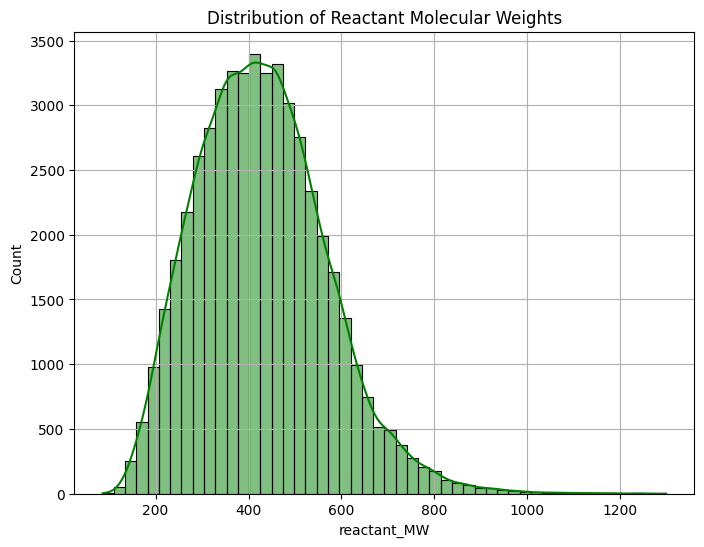

In [30]:
plt.figure(figsize=(8, 6))
sns.histplot(df['reactant_MW'], bins=50, color='green', kde=True)
plt.title("Distribution of Reactant Molecular Weights")
plt.xlabel("reactant_MW")
plt.ylabel("Count")
plt.grid(True)
plt.show()

### Distribution of Reactant Molecular Weights

This histogram shows the distribution of molecular weights (reactant_MW) for the reactants in the dataset.

- Most reactants have MW between 300–500 g/mol.
- The distribution is right-skewed, indicating that while most reactants are moderate in size, a small number of reactions involve much heavier molecules.
- The green KDE curve provides a smoothed estimate of the distribution shape.
- Potential outliers above 1000 g/mol may require filtering or transformation for model stability.

Understanding this distribution is essential for data cleaning, feature engineering, and choosing appropriate modeling techniques.


# Outlier Detection

To find extreme chemical structures that could skew model training.

In [31]:
# Simple IQR-based filtering
Q1 = df['reactant_MW'].quantile(0.25)
Q3 = df['reactant_MW'].quantile(0.75)
IQR = Q3 - Q1
outliers = df[(df['reactant_MW'] < (Q1 - 1.5 * IQR)) | (df['reactant_MW'] > (Q3 + 1.5 * IQR))]

print(f"Found {len(outliers)} outlier reactions based on MW.")


Found 562 outlier reactions based on MW.


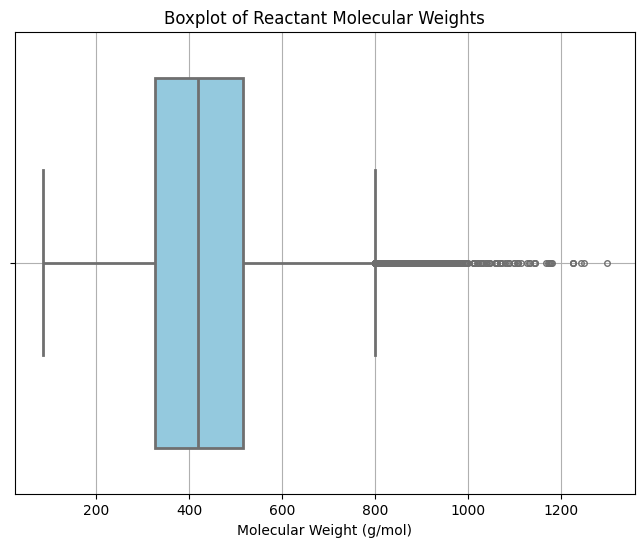

In [32]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['reactant_MW'], color='skyblue', fliersize=4, linewidth=2)
plt.title("Boxplot of Reactant Molecular Weights")
plt.xlabel("Molecular Weight (g/mol)")
plt.grid(True)
plt.show()

### Boxplot of Reactant Molecular Weights

This boxplot displays the distribution and outliers of molecular weights of reactants in the dataset.

- The majority of molecules fall within the 300–700 g/mol range.
- The box represents the interquartile range (IQR), and the line shows the median.
- Several outliers beyond ~800 g/mol suggest the presence of particularly large or complex reactant structures.

Understanding outliers is important for data cleaning, model robustness, and exploring chemical diversity in the dataset.
